# Identifying Fraud from Enron Emails

In [1]:
#import all modules which are listed in poi_id
from poi_id import *

All modules, including helper_functions.py, are loaded from the poi_id file. 

In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
financial_features = ['salary', 'deferral_payments', 'total_payments', \
                     'loan_advances', 'bonus', 'restricted_stock_deferred',\
                     'deferred_income', 'total_stock_value', 'expenses', \
                     'exercised_stock_options', 'other', 'long_term_incentive', \
                     'restricted_stock', 'director_fees'] #(all units are in US dollars)

email_features = ['to_messages', 'from_poi_to_this_person',
                 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
#(units are generally number of emails messages; notable exception is ‘email_address’, 
# which is a text string)
#email_address feature was removed from list

poi_label = ['poi'] ###(boolean, represented as integer)

features_list = poi_label + email_features + financial_features

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset_unix.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
#convert to a pandas dataframe for exploratory analysis
df = pd.DataFrame.from_dict(data_dict, orient='index')

#iterate df and convert string 'NaN' to actual np.nan
for label, content in df.items():
    if label == 'email_address':
         for i in content:
            if i == 'NaN':
                df[label][i] = np.nan            
    else:
        df[label] = pd.to_numeric(df[label], errors='coerce')

Above I defined a list of features and loaded the data into a Panda’s DataFrame. This will simplify the exploratory analysis that follows. I replaced the string ‘NaN’ with actual values for NaN to correctly identify missing values. I also removed the feature 'email_address' because it is a unique identifier that does not contribute towards being a person of interest. It is also a string datatype while the rest are numeric, and removing this unnecessary feature will allow the rest to be equally scaled/normalized.

### Investigate contents of dataset:

In [5]:
# Total Number of data points
total_people = df.shape[0]
print 'The total number of data points (people) in our data set is {}.\n'.format\
      (total_people)

The total number of data points (people) in our data set is 146.



In [6]:
# Total Number of Features Used
all_features = df.shape[1]
print 'There are {} features for each person in our dataset.\n'.format(all_features)

There are 21 features for each person in our dataset.



In [7]:
# Total Number of Persons Of Interest (POIs)
poi_count = df['poi'][(df['poi'] == True)].count()
print 'Our dataset has {} persons of interest.\n'.format(poi_count)

Our dataset has 18 persons of interest.



In [8]:
# Total Number of Non-POIs
non_poi_count = total_people - poi_count
print 'Our dataset has {} Non persons of interest.\n'.format(non_poi_count)

Our dataset has 128 Non persons of interest.



In [9]:
# Features with missing values?
print 'The following categories have missing values (NaN values)\n'
print df.isna().sum()

The following categories have missing values (NaN values)

salary                        51
to_messages                   60
deferral_payments            107
total_payments                21
exercised_stock_options       44
bonus                         64
restricted_stock              36
shared_receipt_with_poi       60
restricted_stock_deferred    128
total_stock_value             20
expenses                      51
loan_advances                142
from_messages                 60
other                         53
from_this_person_to_poi       60
poi                            0
director_fees                129
deferred_income               97
long_term_incentive           80
email_address                  0
from_poi_to_this_person       60
dtype: int64


Above we can see we have numerous categories that have missing values. We also have some unevenly distributed classes with there being only 18 POIs and 128 Non-POIs.  Next, I will plot a few features of interest to help visualize some extreme datapoint outliers.

### Task 2: Remove outliers

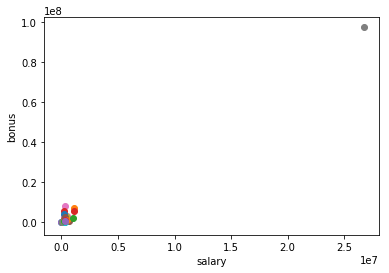

In [10]:
visualize_features('salary', 'bonus', data_dict)

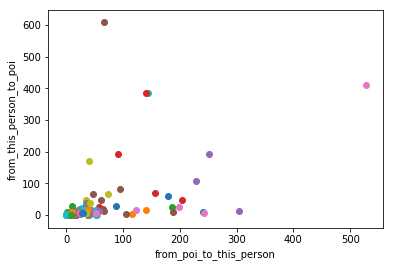

In [11]:
visualize_features('from_poi_to_this_person', 'from_this_person_to_poi', data_dict)

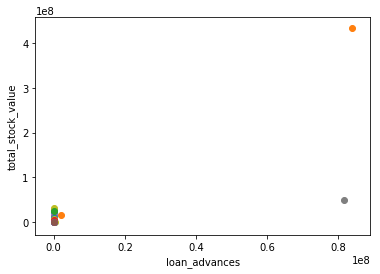

In [12]:
visualize_features('loan_advances', 'total_stock_value', data_dict)

Above we can see some outliers that are present in all the features, this will be explored further to help locate the source.

In [13]:
print 'Searching for Outliers...'
find_outlier('salary', df)
print 
find_outlier('bonus', df)
print
find_outlier('from_poi_to_this_person', df)
print 
find_outlier('from_this_person_to_poi', df)
print 
find_outlier('loan_advances', df)
print 
find_outlier('total_stock_value', df)

Searching for Outliers...

The top 4 highest salary are: 

TOTAL                 26704229.0
SKILLING JEFFREY K     1111258.0
LAY KENNETH L          1072321.0
FREVERT MARK A         1060932.0
Name: salary, dtype: float64


The top 4 highest bonus are: 

TOTAL                 97343619.0
LAVORATO JOHN J        8000000.0
LAY KENNETH L          7000000.0
SKILLING JEFFREY K     5600000.0
Name: bonus, dtype: float64


The top 4 highest from_poi_to_this_person are: 

LAVORATO JOHN J     528.0
DIETRICH JANET R    305.0
KITCHEN LOUISE      251.0
FREVERT MARK A      242.0
Name: from_poi_to_this_person, dtype: float64


The top 4 highest from_this_person_to_poi are: 

DELAINEY DAVID W    609.0
LAVORATO JOHN J     411.0
KEAN STEVEN J       387.0
BECK SALLY W        386.0
Name: from_this_person_to_poi, dtype: float64


The top 4 highest loan_advances are: 

TOTAL               83925000.0
LAY KENNETH L       81525000.0
FREVERT MARK A       2000000.0
PICKERING MARK R      400000.0
Name: loan_advances,

The person ‘TOTAL’ appears at the top of a large majority of our categories. This is obviously just a sum of values for all persons in the dataset. This person is not a POI and can be removed from our dataset. The user ‘LAY KENNETH L’, is also present at the top of several of these feature lists. While he would seem to be an outlier, he is actual a POI and will be included as part of my analysis.  

In [14]:
#get a count of number of NaN columns for each person
nan_count = df.isna().sum(axis=1)

print '\nThe top 5 people by number of NaN columns are:\n'
print nan_count.sort_values(ascending=False).head(5)


The top 5 people by number of NaN columns are:

LOCKHART EUGENE E                19
GRAMM WENDY L                    17
WROBEL BRUCE                     17
WODRASKA JOHN                    17
THE TRAVEL AGENCY IN THE PARK    17
dtype: int64


Above, I wanted to see what users had the most ‘NaN’ columns in our dataset. I sorted these by the top 5 users that have columns with missing values. 

In [15]:
print '\nLooking closer at Eugene Lockhart...\n'
print df.loc['LOCKHART EUGENE E']


Looking closer at Eugene Lockhart...

salary                         NaN
to_messages                    NaN
deferral_payments              NaN
total_payments                 NaN
exercised_stock_options        NaN
bonus                          NaN
restricted_stock               NaN
shared_receipt_with_poi        NaN
restricted_stock_deferred      NaN
total_stock_value              NaN
expenses                       NaN
loan_advances                  NaN
from_messages                  NaN
other                          NaN
from_this_person_to_poi        NaN
poi                          False
director_fees                  NaN
deferred_income                NaN
long_term_incentive            NaN
email_address                  NaN
from_poi_to_this_person        NaN
Name: LOCKHART EUGENE E, dtype: object


The user ‘LOCKHART EUGENE E’ has missing values for all columns except POI, which was false since he was not on the original POI list. This user will be removed from the dataset since he has no useful information. 

In [16]:
print '\nLooking closer at THE TRAVEL AGENCY IN THE PARK...\n'
print df.loc['THE TRAVEL AGENCY IN THE PARK']


Looking closer at THE TRAVEL AGENCY IN THE PARK...

salary                          NaN
to_messages                     NaN
deferral_payments               NaN
total_payments               362096
exercised_stock_options         NaN
bonus                           NaN
restricted_stock                NaN
shared_receipt_with_poi         NaN
restricted_stock_deferred       NaN
total_stock_value               NaN
expenses                        NaN
loan_advances                   NaN
from_messages                   NaN
other                        362096
from_this_person_to_poi         NaN
poi                           False
director_fees                   NaN
deferred_income                 NaN
long_term_incentive             NaN
email_address                   NaN
from_poi_to_this_person         NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object


The user ‘THE TRAVEL AGENCY IN THE PARK’ seems out of place to be a POI. Is this a business? A person? The alias of some illegal money laundering scheme? The only features this user has are for total_payments and other, with the same value for each. I am going to remove this user from my investigation. 

In [17]:
### Remove outliers
df = df.drop(['TOTAL'], axis=0)
df = df.drop(["LOCKHART EUGENE E"], axis=0)
df = df.drop(["THE TRAVEL AGENCY IN THE PARK"], axis=0)

#replace NaN with 0
df = df.fillna(0)

Above I dropped the 3 users that seemed to be outliers. I also filled all missing values with the value of 0. Next I will create some new features that could be of use for my investigation.  

### Task 3: Create new feature(s)

In [18]:
### Store to my_dataset for easy export below.
my_dataset = df.to_dict('index')

In [19]:
for person in my_dataset:
    to_poi_count = my_dataset[person]['from_this_person_to_poi']
    from_poi_count = my_dataset[person]['from_poi_to_this_person']
    total_received_emails = my_dataset[person]['from_messages']
    total_sent_emails = my_dataset[person]['to_messages']
    
    try:
        my_dataset[person]['to_poi_ratio'] = float(to_poi_count) / float(total_sent_emails)
    except:
        my_dataset[person]['to_poi_ratio'] = 0
    try:
        my_dataset[person]['from_poi_ratio'] = float(from_poi_count) / float(total_received_emails)
    except:
        my_dataset[person]['from_poi_ratio'] = 0

features_list = features_list + ['to_poi_ratio', 'from_poi_ratio']
pprint(features_list)

['poi',
 'to_messages',
 'from_poi_to_this_person',
 'from_messages',
 'from_this_person_to_poi',
 'shared_receipt_with_poi',
 'salary',
 'deferral_payments',
 'total_payments',
 'loan_advances',
 'bonus',
 'restricted_stock_deferred',
 'deferred_income',
 'total_stock_value',
 'expenses',
 'exercised_stock_options',
 'other',
 'long_term_incentive',
 'restricted_stock',
 'director_fees',
 'to_poi_ratio',
 'from_poi_ratio']


I created two new features to investigate the percentage of emails a person sent to and received from a person of interest, out of their total emails sent/received. This percentage should reflect unusual levels of communication with persons of interest.   

### Preprocessing

In [20]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [21]:
#Scaling features (normalizing all features)
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

Above, I scaled all features to be between the minimum and maximum values. This will provide equal weight for all features.    

In [22]:
### Select the best features:
# Removes all but the k highest scoring features
n = 6 # adjust for optimization
skb = SelectKBest(f_classif, k=n)
skb.fit_transform(features, labels)
pprint(sorted(skb.scores_, reverse=True))

[24.815079733218194,
 24.182898678566872,
 20.792252047181538,
 18.289684043404513,
 11.458476579280697,
 9.922186013189839,
 9.212810621977086,
 8.772777730091681,
 8.589420731682377,
 7.184055658288725,
 6.094173310638967,
 5.243449713374957,
 5.12394615275689,
 4.1874775069953785,
 4.094653309576945,
 2.3826121082276743,
 2.126327802007705,
 1.6463411294420094,
 0.2246112747360051,
 0.16970094762175436,
 0.06549965290989124]


In [23]:
#skip poi feature and combine with returned scores (key:value --> feature:score)
scores = zip(features_list[1:], skb.scores_)

#sort by highest scoring feature from scores
sorted_scores = sorted(scores, key = lambda x: x[1], reverse=True)
print '\nOur {} highest feature scores are:'.format(n)
pprint(sorted_scores[:n])
                                      
#add k highest scoring features to create new features_list
new_features_list = poi_label + list(map(lambda x: x[0], sorted_scores))[:n]
print '\nOur new features list includes: '
pprint(new_features_list)


Our 6 highest feature scores are:
[('exercised_stock_options', 24.815079733218194),
 ('total_stock_value', 24.182898678566872),
 ('bonus', 20.792252047181538),
 ('salary', 18.289684043404513),
 ('deferred_income', 11.458476579280697),
 ('long_term_incentive', 9.922186013189839)]

Our new features list includes: 
['poi',
 'exercised_stock_options',
 'total_stock_value',
 'bonus',
 'salary',
 'deferred_income',
 'long_term_incentive']


In [24]:
### Extract features and labels from dataset using new optimized features_list
data = featureFormat(my_dataset, new_features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

I used the SelectKBest classifier to find the features that had the strongest influence on determining a POI. I adjusted the value for k to be between 2-10 and found that the best scoring algorithm used 6 features. These features, including the feature ‘poi’, were then added to a newly optimized feature list. 

By normalizing the data and selecting the best features, I have enough to do a preliminary investigation using out of the box algorithms. Next, I will try fitting a variety of these algorithms with my data. 

### Task 4: Try a variety of classifiers

In [25]:
print ('\nRunning GaussianNB classifier...')
run_classifier(GaussianNB(), features, labels)


Running GaussianNB classifier...

For 100 iterations of different features/labels splits, our results are:
Mean Accuracy Score is: 0.859047619048
Median Accuracy Score is: 0.857142857143

Mean Precision Score is: 0.440170634921
Median Precision Score is: 0.4

Mean Recall Score is: 0.378
Median Recall Score is: 0.4

Mean f1 Score is: 0.38295611578
Median f1 Score is: 0.4


In [26]:
print ('\nRunning SVM classifier...')
run_classifier(SVC(), features, labels)


Running SVM classifier...

For 100 iterations of different features/labels splits, our results are:
Mean Accuracy Score is: 0.880952380952
Median Accuracy Score is: 0.880952380952

Mean Precision Score is: 0.0
Median Precision Score is: 0.0

Mean Recall Score is: 0.0
Median Recall Score is: 0.0

Mean f1 Score is: 0.0
Median f1 Score is: 0.0


In [27]:
print ('\nRunning AdaBoost classifier...')
run_classifier(AdaBoostClassifier(), features, labels)


Running AdaBoost classifier...

For 100 iterations of different features/labels splits, our results are:
Mean Accuracy Score is: 0.823333333333
Median Accuracy Score is: 0.833333333333

Mean Precision Score is: 0.217865079365
Median Precision Score is: 0.2

Mean Recall Score is: 0.19
Median Recall Score is: 0.2

Mean f1 Score is: 0.193690642691
Median f1 Score is: 0.2


In [28]:
print ('\nRunning DecisionTree classifier...')
run_classifier(DecisionTreeClassifier(), features, labels)


Running DecisionTree classifier...

For 100 iterations of different features/labels splits, our results are:
Mean Accuracy Score is: 0.806428571429
Median Accuracy Score is: 0.809523809524

Mean Precision Score is: 0.241436840937
Median Precision Score is: 0.25

Mean Recall Score is: 0.282
Median Recall Score is: 0.2

Mean f1 Score is: 0.249292038027
Median f1 Score is: 0.222222222222


Above, the run_classifier function used the train_test_split cross validation technique to split the data into different groups of training and test sets. I used the stratify parameter to ensure the test/training splits included the same ratio of POI labels in each set. I hard coded the function to run a default of 100 iterations, thus 100 different groups of training and testing data. I then calculated the mean and median for accuracy score, precision score, recall score, and f1 scores for each algorithm. The best results came from the GaussianNB Classifier. 

Next, I will adjust various parameters to try to fine tune each algorithm for better performance.  

### Task 5: Tune your classifier to achieve better than .3 precision and recall 

In [29]:
### RE-Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

Above, I reinitialized my labels and features using the full features_list that included the two new features I created. I will use this original (unscaled) form of the data below when I fit each algorithm using a combination of a Pipeline and GridSearchCV to find the ideal set of parameters that maximizes each algorithm.

In [30]:
# Adjust SVM parameters to refine accuracy
print ('\nThe best fit SVM has the following scores:\n')
svm_steps = [('scaler', MinMaxScaler()), ('SKB', SelectKBest()),
             ('SVM', SVC())]
svm_parameters = {'SVM__kernel': ('linear', 'rbf'), 
              'SVM__C':[0.001, 0.01, .1, 1, 10, 100, 1000], 
              'SVM__gamma':[0.01, .1, 1, 10, 100, 1000],
                 'SKB__k': [2,3,4,5,6,7,8,9,10]}
svm_clf = fine_tune_algorithm(svm_steps, svm_parameters, features, labels)


The best fit SVM has the following scores:

Accuracy Score: 0.906976744186
Precision Score: 1.0
Recall Score: 0.2
F1 Score: 0.333333333333

The best fit parameters are:
SVM__C : 10
SVM__gamma : 100
SVM__kernel : rbf
SKB__k : 4


In [31]:
# Adjust DecisionTreeClassifier parameters to refine accuracy
print ('\nThe best fit DecisionTreeClassifer has the following scores:\n')
dt_steps = [('scaler', MinMaxScaler()), ('SKB', SelectKBest()), 
            ('DT', DecisionTreeClassifier())]
dt_parameters = {'DT__criterion': ('gini', 'entropy'), 
              'DT__min_samples_split':[2,3,4,5,6,7,8,9,10],
                 'DT__random_state':[13],
                 'SKB__k': [2,3,4,5,6,7,8,9,10]}
dt_clf = fine_tune_algorithm(dt_steps, dt_parameters, features, labels)


The best fit DecisionTreeClassifer has the following scores:

Accuracy Score: 0.813953488372
Precision Score: 0.285714285714
Recall Score: 0.4
F1 Score: 0.333333333333

The best fit parameters are:
DT__criterion : gini
SKB__k : 5
DT__min_samples_split : 2
DT__random_state : 13


In [32]:
# Adjust AdaBoostClassifier parameters to refine accuracy
print ('\nThe best fit AdaBoostClassifier has the following scores:\n')
ab_steps = [('scaler', MinMaxScaler()), ('SKB', SelectKBest()),
            ('AB', AdaBoostClassifier())]
ab_parameters = {'AB__algorithm': ('SAMME', 'SAMME.R'), 
              'AB__learning_rate':[.5, .6, .7, .8, .9, 1],
                 'SKB__k': [2,3,4,5,6,7,8,9,10]}
ada_clf = fine_tune_algorithm(ab_steps, ab_parameters, features, labels)


The best fit AdaBoostClassifier has the following scores:

Accuracy Score: 0.860465116279
Precision Score: 0.333333333333
Recall Score: 0.2
F1 Score: 0.25

The best fit parameters are:
SKB__k : 5
AB__learning_rate : 0.9
AB__algorithm : SAMME


In [33]:
# Adjust GaussianNB parameters to refine accuracy
print ('\nThe best fit GaussianNB Classifier has the following scores:\n')
nb_steps = [('scaler', MinMaxScaler()), ('SKB', SelectKBest()), ('NB', GaussianNB())]
nb_parameters = {'SKB__k': [2,3,4,5,6,7,8,9,10]}
nb_clf = fine_tune_algorithm(nb_steps, nb_parameters, features, labels)


The best fit GaussianNB Classifier has the following scores:

Accuracy Score: 0.837209302326
Precision Score: 0.333333333333
Recall Score: 0.4
F1 Score: 0.363636363636

The best fit parameters are:
SKB__k : 4


Above, I used a function I created, fine_tune_algorithm, to try a variety of parameters using the GridSearchCV method. In this function I implemented a sklearn Pipeline to first use a MinMaxScaler to scale the features, the SelectKBest algorithm to find the best features, then a variety of specific algorithm parameters to try finding the best fitting model.

With the GridSearchCV algorithm I used the scoring parameter to fit the algorithm based on the best f1 score found. I know f1 score is a good point of balance between precision and recall and felt it was the best indication of a well performing fit. 

Ultimately the GaussianNB algorithm again proved to be the best overall with good scores for accuracy, precision, recall, and f1 score. This will be the final one I submit for the project. It utilizes the best 4 features it determined using SelectKBest and is the best fitting model. 
